In [13]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 

##  Convolutional Neural Network (CNN)
- Fashion MNIST
- Dataset From CSV File
- Demo CNN Network

In [14]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf

    
%matplotlib inline

In [15]:
###----------------------
### Some basic parameters
###----------------------


inpDir = './' # location where input data is stored
outDir = './' # location to store outputs
modelDir = './'
subDir = './'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE) # setting for TensorFlow as well


EPOCHS = 10 # number of cycles to run


BATCH_SIZE = 16 # inline with Train Rows being 60000 and Test rows being 10000

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,10),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

## Helper Function

In [16]:
###-----------------------------------
### Function to plot Loss Curve
###-----------------------------------

def fn_plot_tf_hist(hist_df : pd.DataFrame):
    '''
    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes 
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

## Using MNIST Fashion data

### Labels

Total : 785 columns
First column is label remaining columns are pixel values of the images.

Each training and test example is assigned to one of the following labels:


|Label| Class
|:-|:-|
0 | T-shirt/top
1 | Trouser
2 | Pullover
3 | Dress
4 | Coat
5 | Sandal
6 | Shirt
7 | Sneaker
8 | Bag
9 | Ankle boot

In [17]:
class_labels ={0 : 'T-shirt/top',
               1 : 'Trouser',
               2 : 'Pullover',
               3 : 'Dress',
               4 : 'Coat',
               5 : 'Sandal',
               6 : 'Shirt',
               7 : 'Sneaker',
               8 : 'Bag',
               9 : 'Ankle boot'
              }

In [18]:
train_filename = os.path.join(inpDir, subDir, 'fashion-mnist_train.csv')
test_filename = os.path.join(inpDir, subDir, 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
test_df = pd.read_csv(test_filename, header = 0)

In [19]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
###-------------------------------
### Define Function to plot labels
###-------------------------------

def fn_plot_label(train_df, test_df):
    plt.figure(figsize=(15,5))
    
    plt.subplot(1,2,1)
    ax = train_df['label'].value_counts().plot(kind = 'bar', title = 'Train', color = 'DarkBlue')
    
    plt.subplot(1,2,2)
    ax = test_df['label'].value_counts().plot(kind = 'bar', title = 'Test', color = 'Orange')

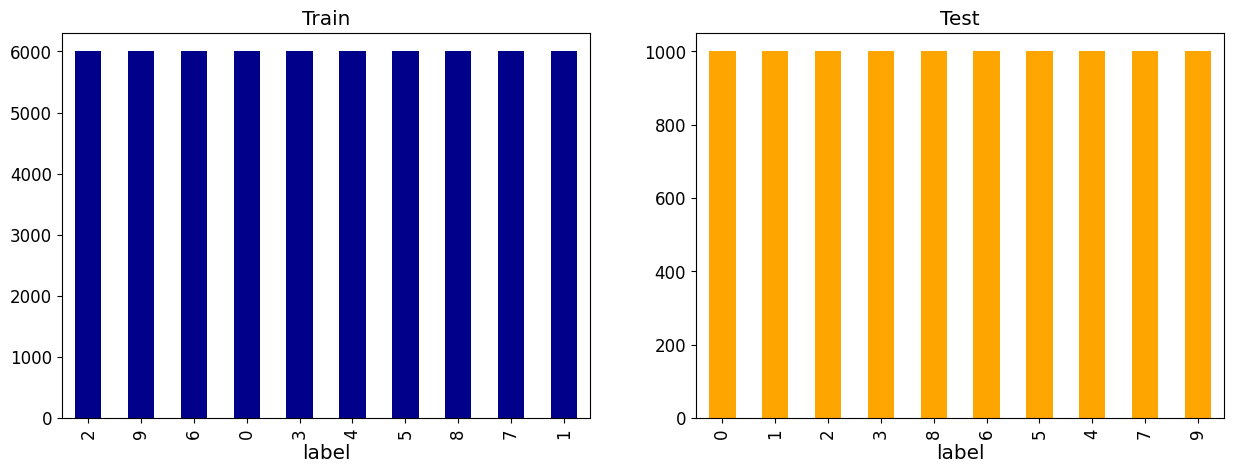

In [22]:
fn_plot_label(train_df, test_df)

## Converting to Features and labels

In [23]:
# Each row need to be separated in features and labels
def fn_split_feature_label(df):
    features = []
    labels = []
    for i, row in df.iterrows():
        feature = np.reshape(row.values[1:], [28,28,1])
        label = row[0]
        features.append(feature)
        labels.append(label)
    return np.array(features), np.array(labels)

In [24]:
X_train, y_train = fn_split_feature_label(train_df)
X_train.shape, y_train.shape

((60000, 28, 28, 1), (60000,))

In [25]:
X_test, y_test = fn_split_feature_label(test_df)
X_test.shape, y_test.shape

((10000, 28, 28, 1), (10000,))

### Verify the data

To verify that the data looks correct, let's plot the first 64 images from the training set and display the class name below each image.


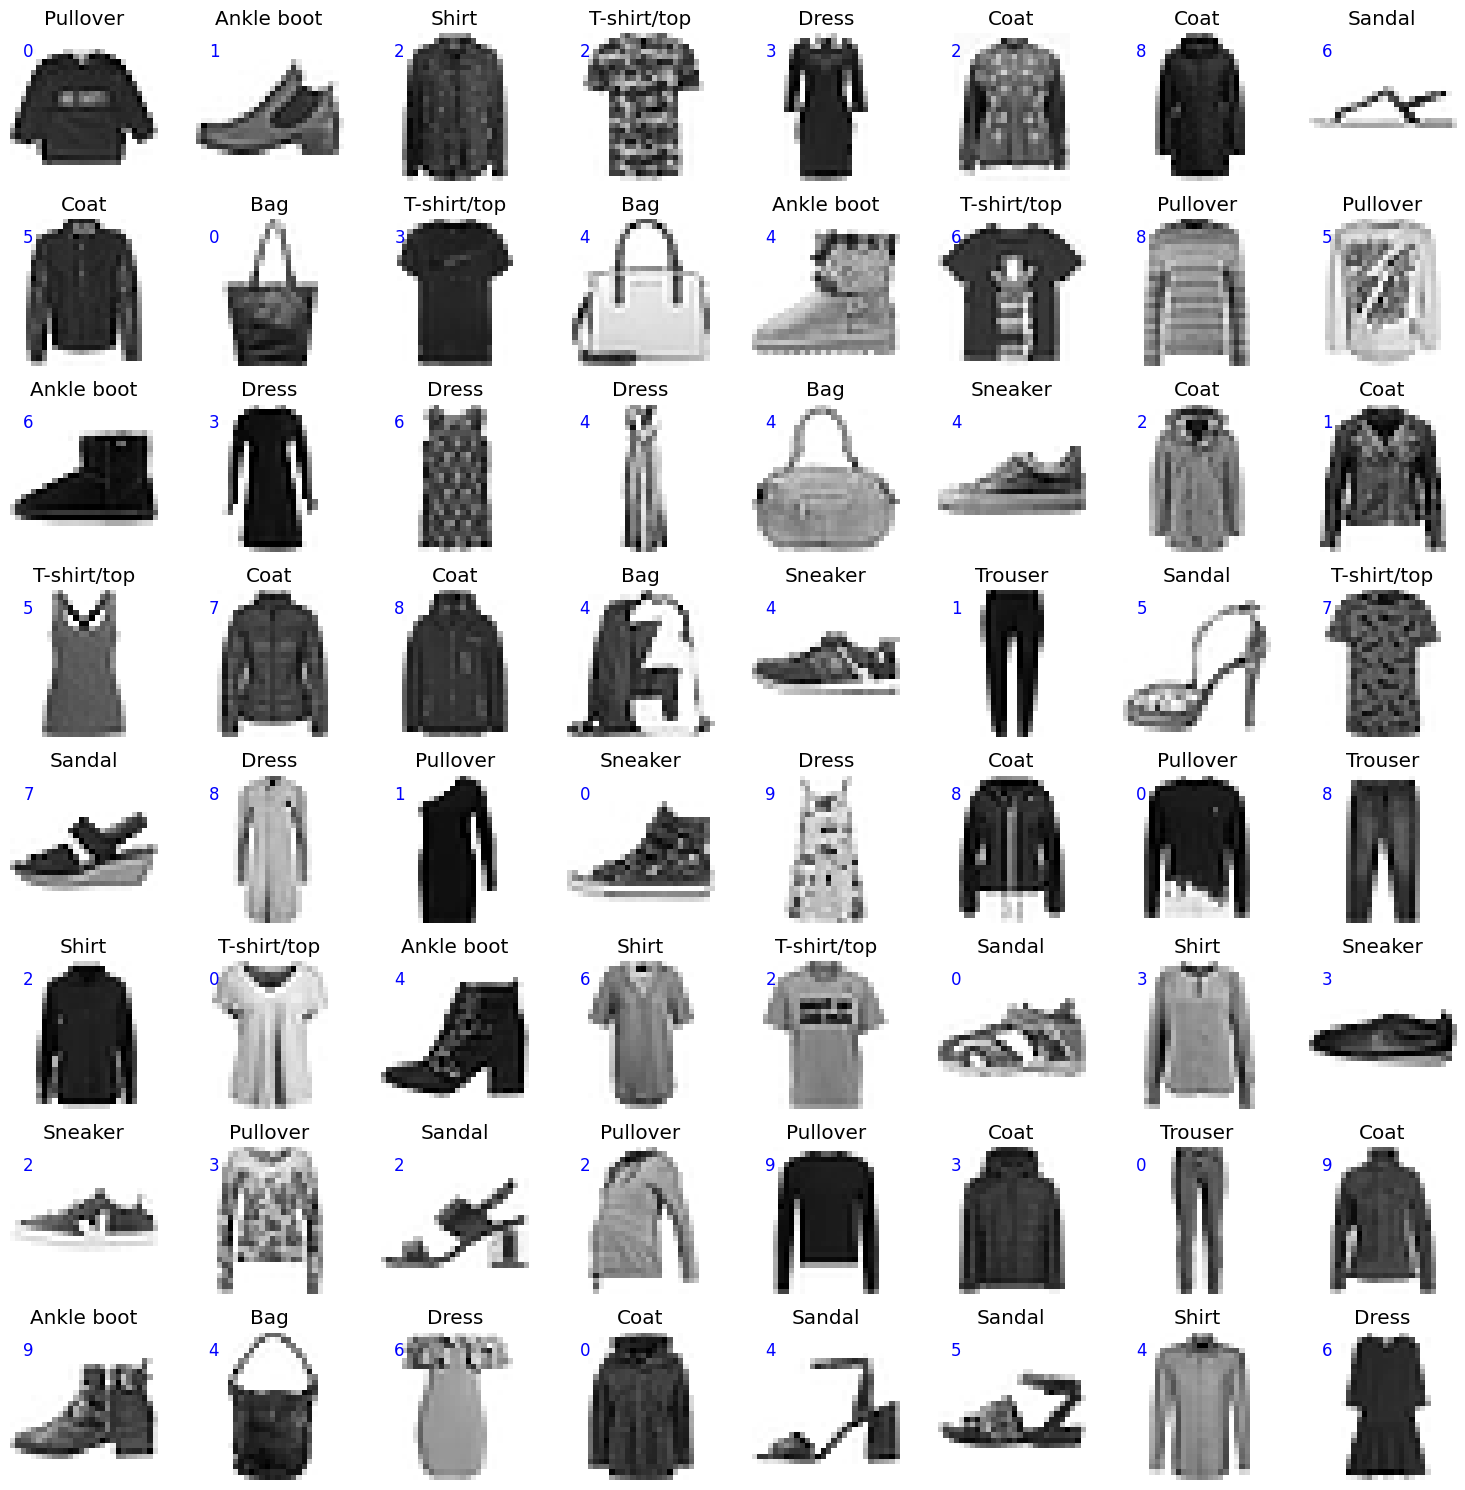

In [26]:
fig = plt.figure(figsize=(15,15))

for i in range(64) :
    
    ax = fig.add_subplot(8,8,i+1) # add axis to the plot
    
    ax.grid(False)

    ax.imshow(X_train[i, :].astype("uint8"), cmap=plt.cm.binary) # display image

    ax.set_title(class_labels[y_train[i]]) # Mark label class

    ax.text(2, 4, y_test[i], color='b', fontsize=12) # mark label 
    
    ax.axis("off")
    
plt.tight_layout()

plt.show()

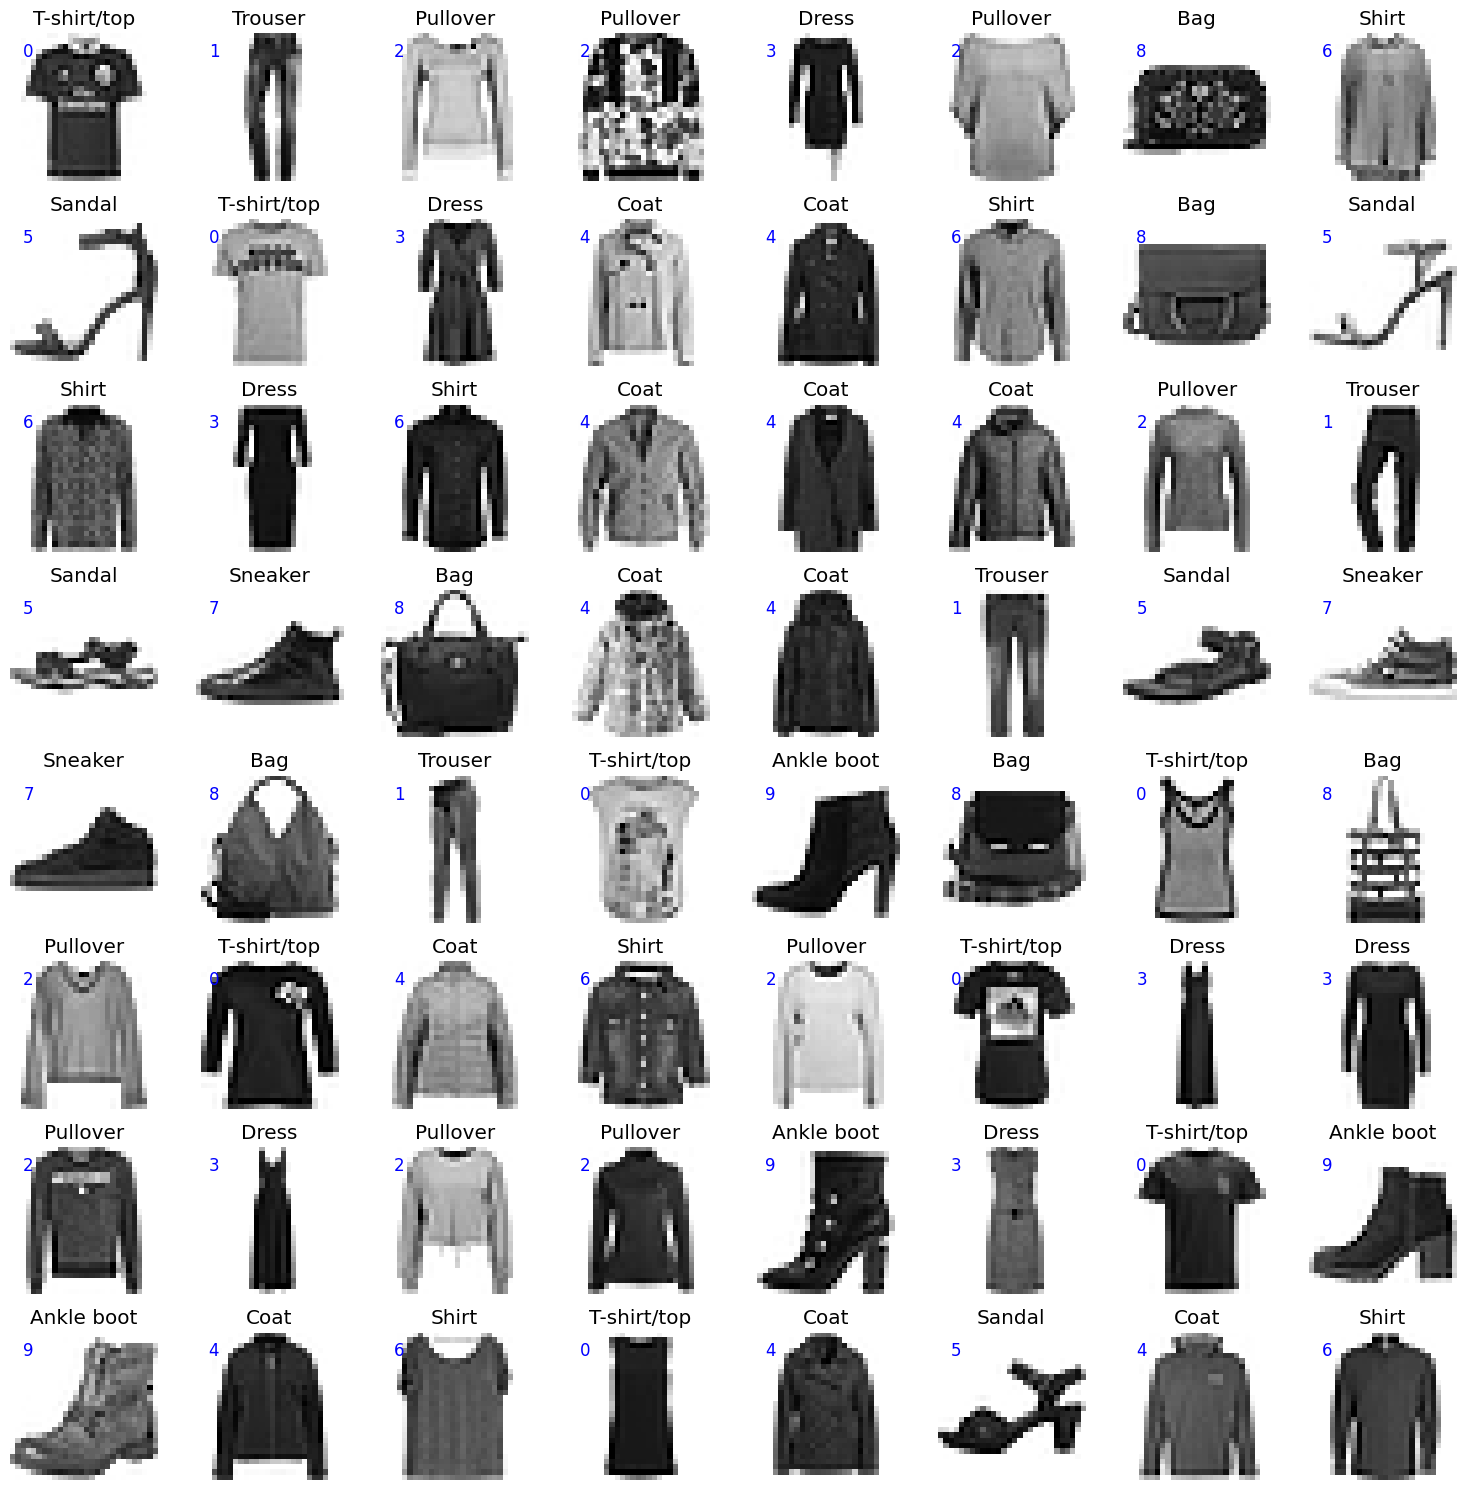

In [27]:
fig = plt.figure(figsize=(15,15))

for i in range(64) :
    
    ax = fig.add_subplot(8,8,i+1)
    
    ax.grid(False)

    ax.imshow(X_test[i, :].astype("uint8"), cmap=plt.cm.binary)

    ax.set_title(class_labels[y_test[i]])
        
    
    ax.text(2, 4, y_test[i], color='b', fontsize=12)
        
    
    ax.axis("off")
    
plt.tight_layout()

plt.show()

## Convolution Layer in Action

In [28]:
input_shape = (1,6,6,1)
X = tf.random.normal(input_shape)
X.shape

TensorShape([1, 6, 6, 1])

<Axes: >

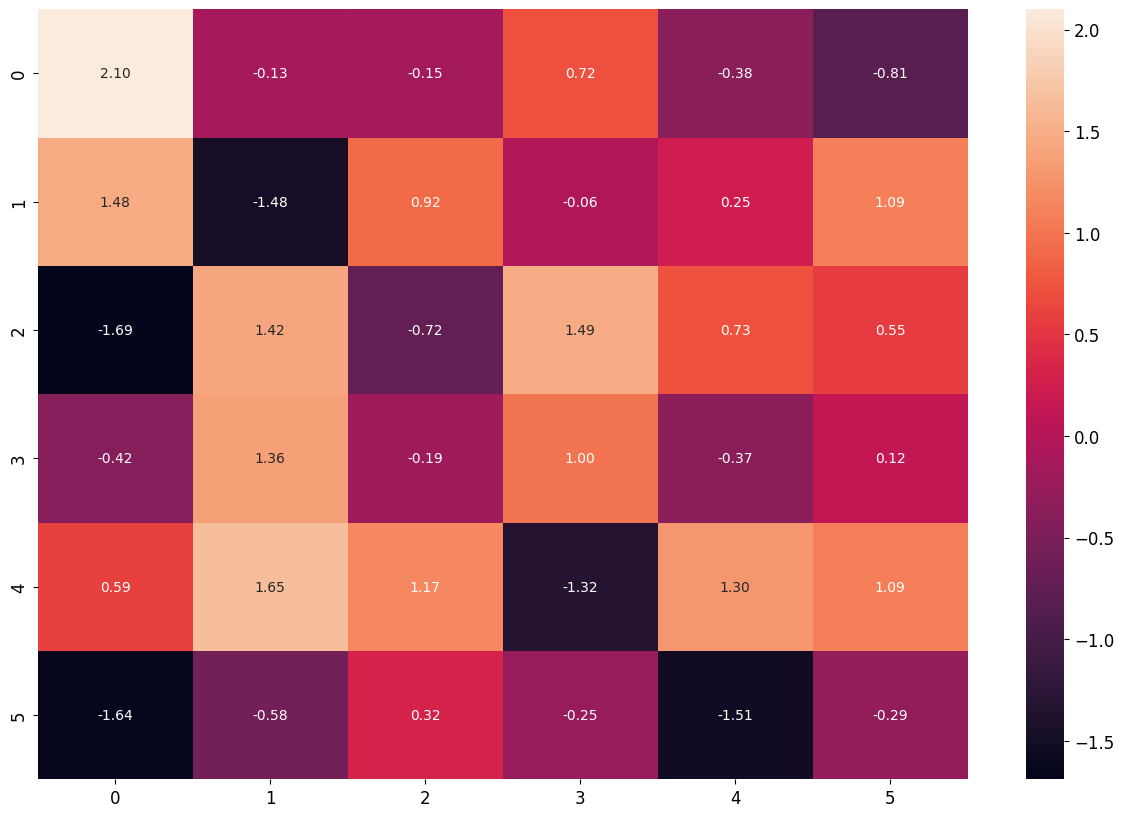

In [29]:
import seaborn as sns
sns.heatmap(X.numpy()[0,:,:,0], annot=True, fmt = '.2f')

In [30]:
tf.constant_initializer(1.).value

1.0

In [31]:
y = tf.keras.layers.Conv2D(1, 3, 
                           kernel_initializer=tf.constant_initializer(1.), 
                           use_bias=False, activation='relu', 
                           input_shape=input_shape[1:]
                           )(X)
y.shape

TensorShape([1, 4, 4, 1])

<Axes: >

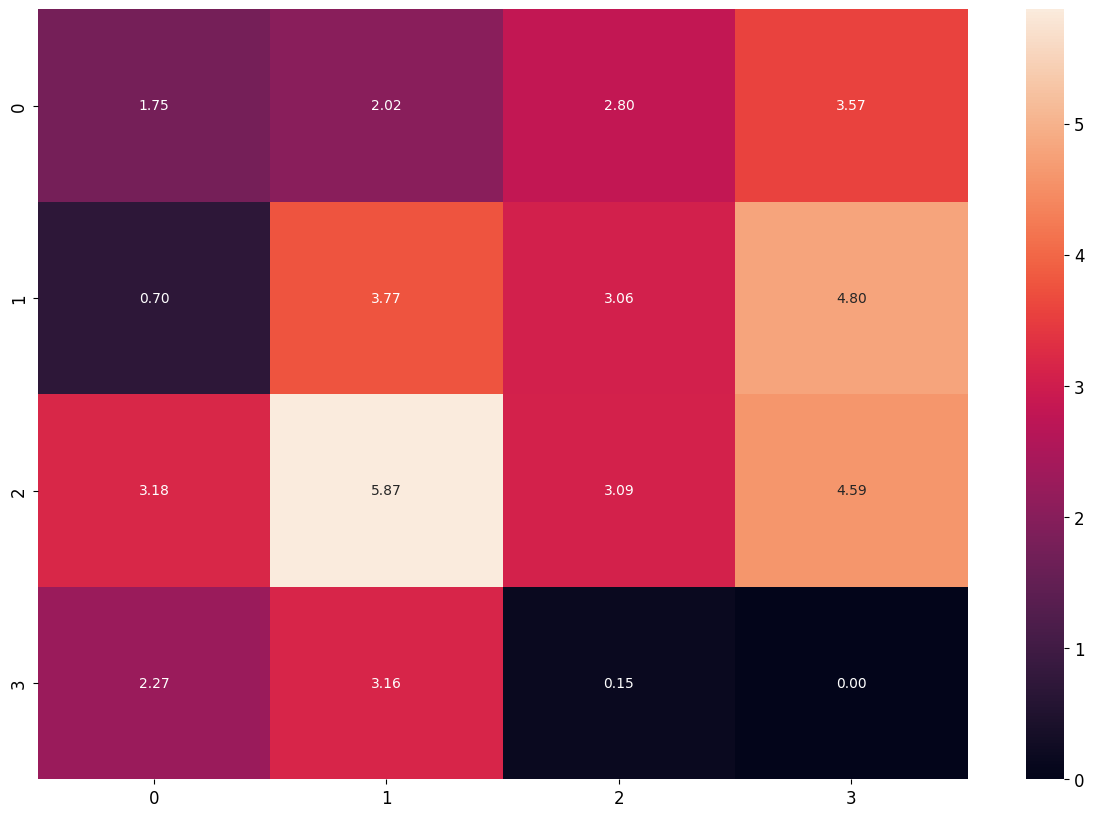

In [32]:
sns.heatmap(y.numpy()[0,:,:,0], annot=True, fmt = '.2f')

## MaxPool Layer in Action

<Axes: >

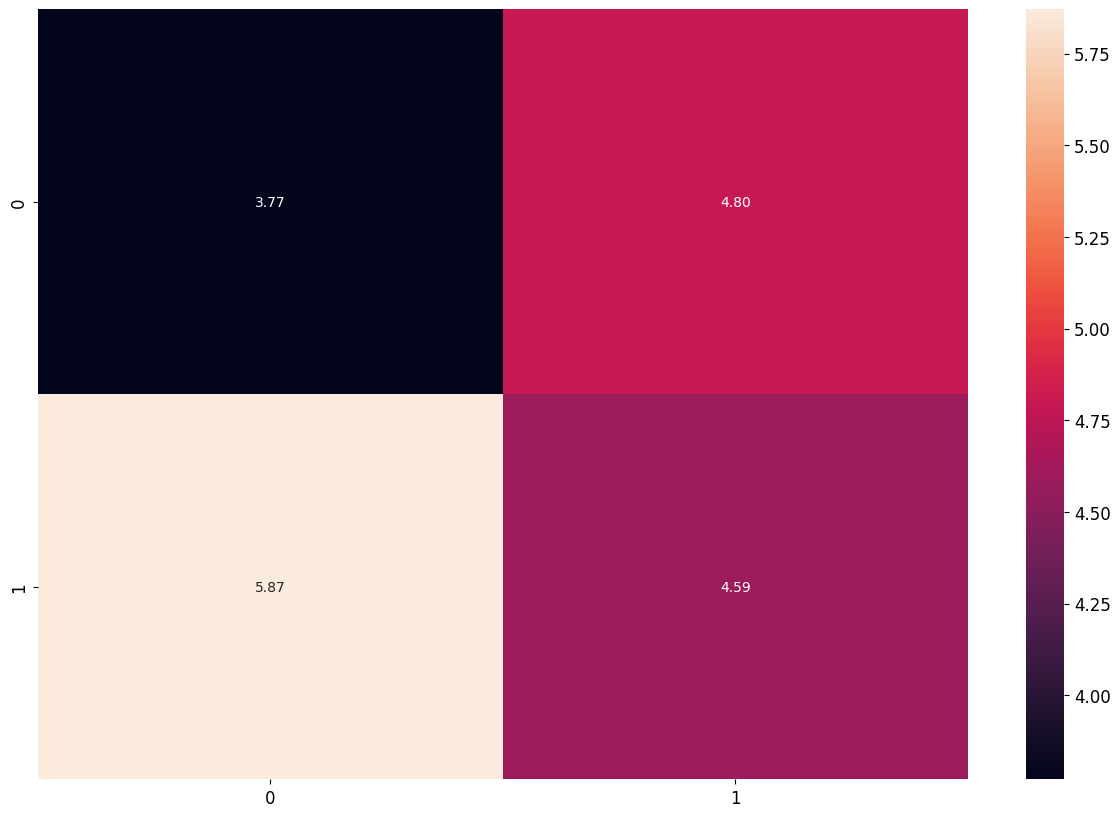

In [33]:
max_pool_2d = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='valid')
z = max_pool_2d(y)

sns.heatmap(z.numpy()[0,:,:,0], annot=True, fmt = '.2f')

## Pooling Layer
>tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), strides=None, padding='valid', data_format=None, **kwargs
)

### Create the Convolution base

<img src = '../../images/dnn_nb_cnn_MNIST.png' style = 'width:800px;' alt="Demo Convolution Network MNIST" align="left">

>tf.keras.layers.Conv2D(
    filters, kernel_size, strides=(1, 1), padding='valid', data_format=None,
    dilation_rate=(1, 1), groups=1, activation=None, use_bias=True,
    kernel_initializer='glorot_uniform', bias_initializer='zeros',
    kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    kernel_constraint=None, bias_constraint=None, **kwargs
)

>tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), strides=None, padding='valid', data_format=None, **kwargs
)

In [34]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Rescaling(1./255))

dor1 = 0.3
dor2 = 0.2
dor3 = 0.2
dor4 = 0.1
dor5 = 0.1



##  SET 1  ##
model.add(tf.keras.layers.Conv2D(32,(3,3), 
                                 padding='same',  
                                 activation='relu',
                                 input_shape=(28, 28,1)
                                 ))


tf.keras.layers.Dropout(dor1)

model.add(tf.keras.layers.MaxPool2D((2,2)))

##  SET 2  ##
model.add(tf.keras.layers.Conv2D(64,(3,3), 
                                 activation='relu', 
                                 ))


tf.keras.layers.Dropout(dor2)
model.add(tf.keras.layers.MaxPool2D((2,2)))

##  SET 3  ##
model.add(tf.keras.layers.Conv2D(128,(3,3), 
                                 activation='relu', 
                                 ))

tf.keras.layers.Dropout(dor3)

In [35]:
model.add(tf.keras.layers.Flatten())

##  DENSE 1
model.add(tf.keras.layers.Dense(64, activation='relu'))
tf.keras.layers.Dropout(dor4)
##  DENSE 2
model.add(tf.keras.layers.Dense(10))

### Compile and train the model

In [36]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=[X_test, y_test])

Epoch 1/10
3750/3750 [==============================] - 37s 10ms/step - loss: 0.4154 - accuracy: 0.8490 - val_loss: 0.2649 - val_accuracy: 0.9041
Epoch 2/10
3750/3750 [==============================] - 33s 9ms/step - loss: 0.2709 - accuracy: 0.9011 - val_loss: 0.2693 - val_accuracy: 0.9024
Epoch 3/10
3750/3750 [==============================] - 31s 8ms/step - loss: 0.2265 - accuracy: 0.9172 - val_loss: 0.2339 - val_accuracy: 0.9136
Epoch 4/10
3750/3750 [==============================] - 32s 8ms/step - loss: 0.1953 - accuracy: 0.9271 - val_loss: 0.2105 - val_accuracy: 0.9232
Epoch 5/10
3750/3750 [==============================] - 32s 8ms/step - loss: 0.1711 - accuracy: 0.9371 - val_loss: 0.2174 - val_accuracy: 0.9223
Epoch 6/10
3750/3750 [==============================] - 31s 8ms/step - loss: 0.1485 - accuracy: 0.9445 - val_loss: 0.2406 - val_accuracy: 0.9136
Epoch 7/10
3750/3750 [==============================] - 31s 8ms/step - loss: 0.1297 - accuracy: 0.9516 - val_loss: 0.2298 - val_a

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (16, 28, 28, 1)           0         
                                                                 
 conv2d_1 (Conv2D)           (16, 28, 28, 32)          320       
                                                                 
 max_pooling2d_1 (MaxPoolin  (16, 14, 14, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (16, 12, 12, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (16, 6, 6, 64)            0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (16, 4, 4, 128)           7

In [38]:
res_df = pd.DataFrame(history.history)
res_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.415383,0.849033,0.264938,0.9041
1,0.270913,0.901150,0.269334,0.9024
2,0.226459,0.917183,0.233904,0.9136
3,0.195350,0.927117,0.210466,0.9232
4,0.171138,0.937133,0.217384,0.9223


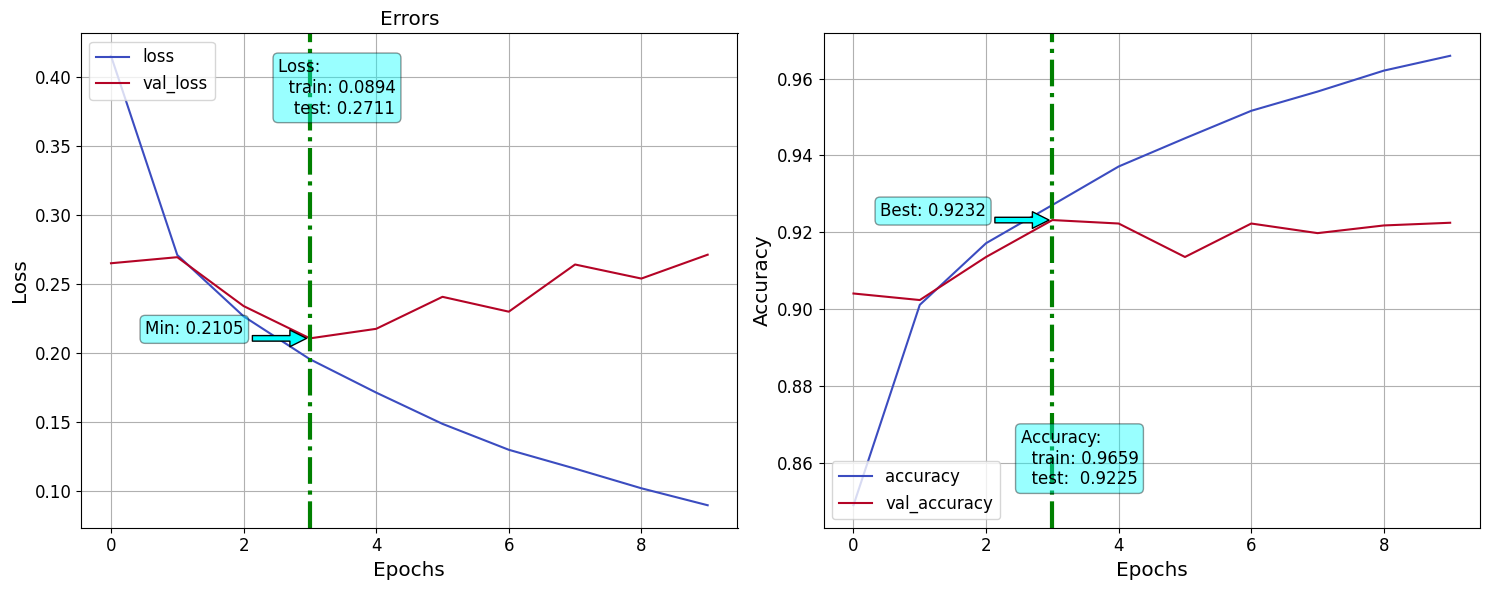

In [39]:
fn_plot_tf_hist(res_df)

### Evaluate the model

In [40]:
test_loss, test_acc = model.evaluate( X_test, y_test, verbose=2)

313/313 - 2s - loss: 0.2711 - accuracy: 0.9225 - 2s/epoch - 5ms/step


In [41]:
yhat = model.predict(X_test)

y_pred = yhat.argmax(axis = 1)

print(f'Accuracy score on Test Data : {accuracy_score(y_test, y_pred) : .4f}')

313/313 [==============================] - 2s 5ms/step
Accuracy score on Test Data :  0.9225



|| |Predicted| class
|:-|:-|:-|:-|
| | |P|N|
Actual|P|TP|FN
class|N|FP|TN

In [42]:
confusion_matrix(y_test, y_pred)

array([[868,   0,  18,  15,   1,   2,  88,   0,   8,   0],
       [  1, 991,   1,   6,   0,   0,   1,   0,   0,   0],
       [ 15,   0, 849,   9,  57,   0,  66,   0,   4,   0],
       [ 15,   5,   7, 928,  25,   0,  18,   0,   1,   1],
       [  2,   1,  20,  19, 907,   0,  50,   0,   1,   0],
       [  0,   0,   0,   0,   0, 979,   0,  15,   2,   4],
       [101,   3,  39,  20,  56,   0, 778,   0,   3,   0],
       [  0,   0,   0,   0,   1,   7,   0, 969,   0,  23],
       [  1,   1,   0,   0,   1,   1,   7,   1, 988,   0],
       [  0,   0,   0,   0,   1,   1,   0,  30,   0, 968]], dtype=int64)

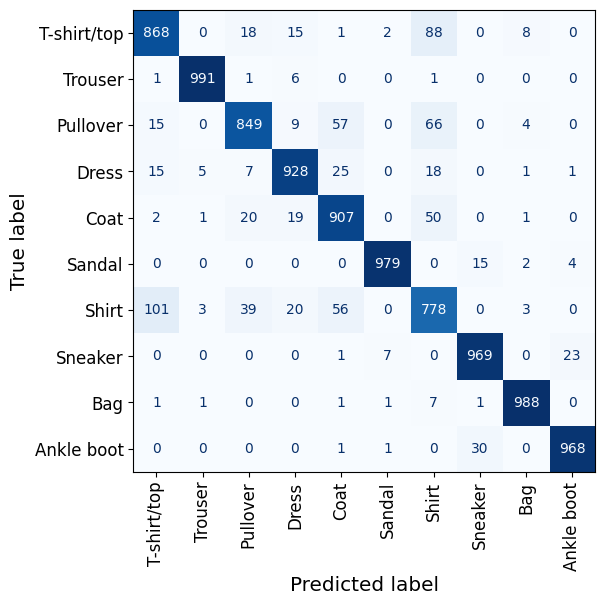

In [43]:
CMAP = plt.cm.Blues

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=class_labels.values())

fig, ax = plt.subplots(figsize = (6,6))

disp.plot(ax = ax, cmap=CMAP, colorbar=False, xticks_rotation=90);

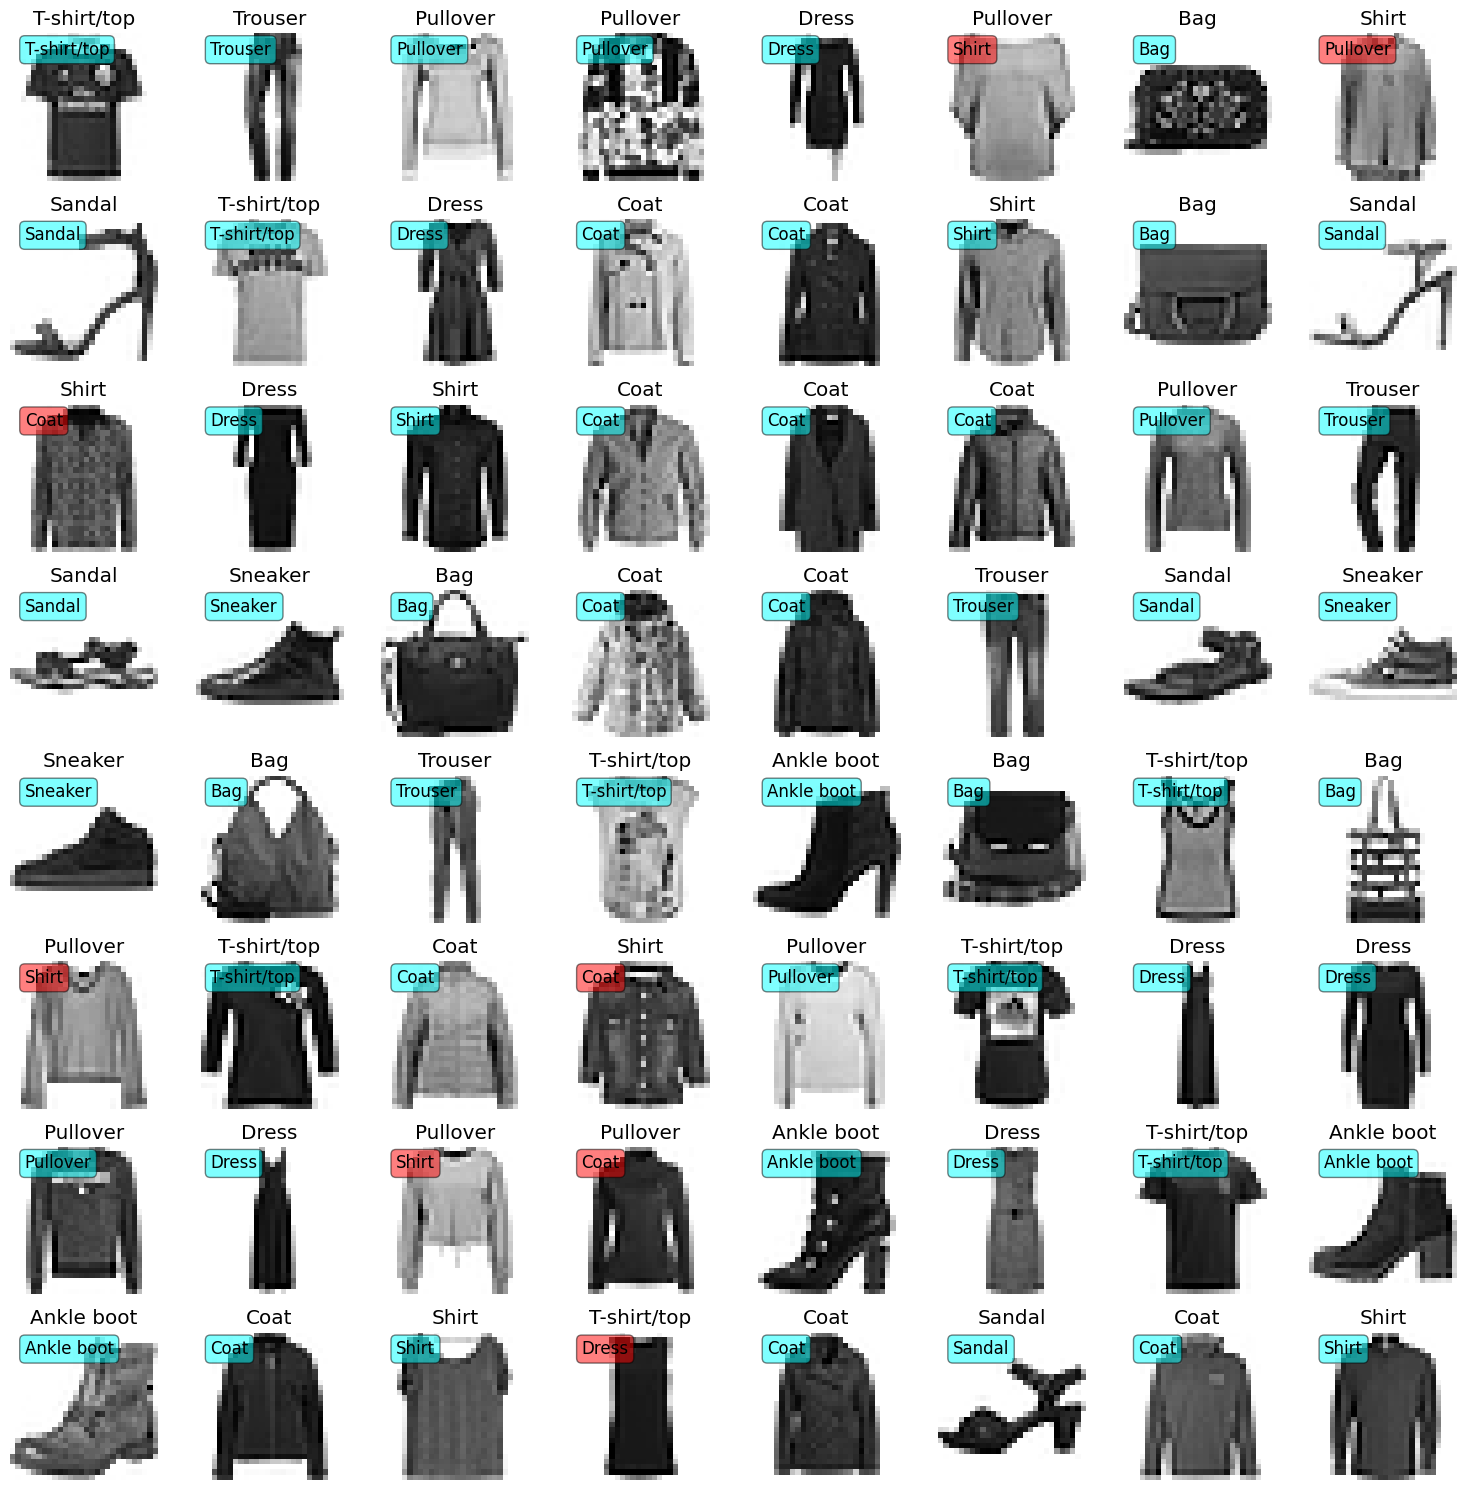

In [44]:
fig = plt.figure(figsize=(15,15)) # figure of size (15, 15)

fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) # adjust subplots

for i in range(64) :
    
    ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[] )
    
    ax.grid(False)

    ax.imshow(X_test[i, :].astype("uint8"), cmap=plt.cm.binary)

    ax.set_title(class_labels[y_test[i]])

    if y_pred[i]!= y_test[i]:
        color = 'red'
    else:
        color = 'cyan'
        
    props = dict(boxstyle='round', facecolor=color, alpha=0.5)
    
    ax.text(0.1, 0.95, class_labels[y_pred[i]], transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)   # add number (class) of the image

    ax.axis("off")
    
plt.tight_layout()

plt.show()

## Assignment:
- Implement Dropout, Batch Normalization and early stopping